# 《长安十二时辰》数据可视化分析

《长安十二时辰》 6 月 27 日上映，豆瓣评分首日便达到了 8 分，热度并不低于当下热播的每一部剧。今天主要是对我用 Python 采集的豆瓣影评进行简单的可视化分析。  
**主要从五个方面分析：**  
- 全国观众地域分布
- 观众地域排行榜
- 短评词云图
- 评论数量与日期的关系
- 影片情感分析
- 各评分占比

### 下面是分析的整个过程

## 一、理解数据

本数据集来源豆瓣，由于豆瓣在非登录状态下仅仅可以爬取200条短评，登录状下也只能可以爬取500条数据，所以数据集只有 500 条评论。包括：
- 观众id
- 观众评论
- 观众地域
- 评论日期
- 推荐指数

# 二、清洗数据

In [1]:
# 导入相关库
import pandas as pd
import matplotlib.pyplot as plt
import jieba
import re
import warnings
from pyecharts.charts import  Geo, Line, Pie, Bar
from chinese_province_city_area_mapper.transformer import CPCATransformer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from snownlp import SnowNLP

warnings.filterwarnings('ignore')

%matplotlib inline

### 1. 数据加载

In [4]:
df1 = pd.read_csv(r'C:\Users\86134\Desktop\长安十二时辰\comments.csv')
df2 = pd.read_csv(r'C:\Users\86134\Desktop\长安十二时辰\cities.csv')
df = pd.merge(df1, df2, left_index=True, right_index=True, how='outer') # 根据索引合并数据

### 2.数据探索

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 0 to 479
Data columns (total 7 columns):
user_id    480 non-null int64
name       480 non-null object
score      480 non-null object
comment    480 non-null object
date       480 non-null object
score1     480 non-null object
city       480 non-null object
dtypes: int64(1), object(6)
memory usage: 50.0+ KB


因为我打算按照城市分布分析，所以把省去掉

In [6]:
df.head()

,user_id,name,score,comment,date,score1,city
0,0,tianya无泪,4,易烊千玺的李必真的很棒了，第一部影视化作品四字弟弟太值得夸。看似清高孤傲，实际情义双全。他演...,6/27/2019,推荐,河北石家庄
1,1,吹哥,4,期待这部剧很久了，感觉唐朝的还原度非常高，装饰的道具都很真实。剧中人物的服装非常精致，就是漂...,6/27/2019,推荐,辽宁大连
2,2,ECHOT,1,希望越大失望越大，一口气看了四五集，不知所云，画面很美，只不过给B站剪辑手提供了很多空境素材...,6/28/2019,很差,"Paris, France"
3,3,陈词,4,雷佳音真是把张小敬的匪气，轻浮，外粗内细演活了。最喜欢他死牢里一抬眼的那股子“狠”劲儿，不想...,6/27/2019,推荐,陕西西安
4,4,雨YING,1,台词太差了，完全没有起伏，出戏,6/28/2019,很差,湖北仙桃


In [7]:
def city_process(line):
    city = re.compile('[^\u4e00-\u9fa5]') # 中文编码范围\u4e00到\u9fa5
    # 取出中文字符，返回列表
    zh = re.split(city, line)
    # 取列表中最后一个，例如'讷河, 齐齐哈尔'取齐齐哈尔
    zh = zh[-1]
    return zh
df['city'] = df['city'].apply(city_process)
# 提取出city中的市
cpca = CPCATransformer()
df['city'] = cpca.transform(df.city)['市']
df.info()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\86134\AppData\Local\Temp\jieba.cache
Loading model cost 1.649 seconds.
Prefix dict has been built succesfully.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 0 to 479
Data columns (total 7 columns):
user_id    480 non-null int64
name       480 non-null object
score      480 non-null object
comment    480 non-null object
date       480 non-null object
score1     480 non-null object
city       480 non-null object
dtypes: int64(1), object(6)
memory usage: 50.0+ KB


In [8]:
df.head()

,user_id,name,score,comment,date,score1,city
0,0,tianya无泪,4,易烊千玺的李必真的很棒了，第一部影视化作品四字弟弟太值得夸。看似清高孤傲，实际情义双全。他演...,6/27/2019,推荐,石家庄市
1,1,吹哥,4,期待这部剧很久了，感觉唐朝的还原度非常高，装饰的道具都很真实。剧中人物的服装非常精致，就是漂...,6/27/2019,推荐,
2,2,ECHOT,1,希望越大失望越大，一口气看了四五集，不知所云，画面很美，只不过给B站剪辑手提供了很多空境素材...,6/28/2019,很差,
3,3,陈词,4,雷佳音真是把张小敬的匪气，轻浮，外粗内细演活了。最喜欢他死牢里一抬眼的那股子“狠”劲儿，不想...,6/27/2019,推荐,西安市
4,4,雨YING,1,台词太差了，完全没有起伏，出戏,6/28/2019,很差,


In [9]:
df1 = df[df['city'] != ''] # 去除城市为空的值

In [10]:
df1.head()

,user_id,name,score,comment,date,score1,city
0,0,tianya无泪,4,易烊千玺的李必真的很棒了，第一部影视化作品四字弟弟太值得夸。看似清高孤傲，实际情义双全。他演...,6/27/2019,推荐,石家庄市
3,3,陈词,4,雷佳音真是把张小敬的匪气，轻浮，外粗内细演活了。最喜欢他死牢里一抬眼的那股子“狠”劲儿，不想...,6/27/2019,推荐,西安市
6,6,花不弃,1,易烊千玺什么辣眼睛的演技，吹太高了吧,6/28/2019,很差,金华市
7,7,美少年不可辜负,1,请问易烊千玺的台词怎么回事？不看字幕听得清在讲什么吗？能不能别闭眼吹了？吞音重成这样还不配音...,6/28/2019,很差,北京市
8,8,克服拖延症,2,千玺表现不错，雷佳音故弄玄虚，油腻的一匹,6/27/2019,较差,上海市


In [96]:
# 提取城市和对应数量
counts = pd.value_counts(df1['city'])
attr = counts.index.to_list()
value = counts[counts.index].to_list()
i = dict(zip(attr ,value))


北京市     75
上海市     40
成都市     19
杭州市     17
广州市     15
苏州市      9
武汉市      9
西安市      8
深圳市      7
长沙市      6
南京市      6
重庆市      6
哈尔滨市     5
天津市      5
郑州市      5
福州市      5
青岛市      3
金华市      3
温州市      2
石家庄市     2
南通市      2
扬州市      2
唐山市      2
宁波市      2
泰州市      2
济南市      2
吉林市      2
合肥市      2
马鞍山市     2
新乡市      1
蚌埠市      1
潍坊市      1
鹤壁市      1
嘉兴市      1
庆阳市      1
邯郸市      1
徐州市      1
丽水市      1
衢州市      1
无锡市      1
怀化市      1
宣城市      1
安阳市      1
张家口市     1
淄博市      1
贵阳市      1
安康市      1
Name: city, dtype: int64

In [97]:
data = [list(k)  for k in i.items()] # 将新得列表
data

[['北京市', 75],
 ['上海市', 40],
 ['成都市', 19],
 ['杭州市', 17],
 ['广州市', 15],
 ['苏州市', 9],
 ['武汉市', 9],
 ['西安市', 8],
 ['深圳市', 7],
 ['长沙市', 6],
 ['南京市', 6],
 ['重庆市', 6],
 ['哈尔滨市', 5],
 ['天津市', 5],
 ['郑州市', 5],
 ['福州市', 5],
 ['青岛市', 3],
 ['金华市', 3],
 ['温州市', 2],
 ['石家庄市', 2],
 ['南通市', 2],
 ['扬州市', 2],
 ['唐山市', 2],
 ['宁波市', 2],
 ['泰州市', 2],
 ['济南市', 2],
 ['吉林市', 2],
 ['合肥市', 2],
 ['马鞍山市', 2],
 ['新乡市', 1],
 ['蚌埠市', 1],
 ['潍坊市', 1],
 ['鹤壁市', 1],
 ['嘉兴市', 1],
 ['庆阳市', 1],
 ['邯郸市', 1],
 ['徐州市', 1],
 ['丽水市', 1],
 ['衢州市', 1],
 ['无锡市', 1],
 ['怀化市', 1],
 ['宣城市', 1],
 ['安阳市', 1],
 ['张家口市', 1],
 ['淄博市', 1],
 ['贵阳市', 1],
 ['安康市', 1]]

## 长安十二时辰观众地域分布

In [56]:
from example.commons import Faker
from pyecharts import options as opts
from pyecharts.charts import Geo
from pyecharts.globals import ChartType, SymbolType


def geo_base() -> Geo:
    c = (
        Geo()
        .add_schema(maptype="china")
        .add("",data)
        .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
        .set_global_opts(
            visualmap_opts=opts.VisualMapOpts(),
            title_opts=opts.TitleOpts(title="长安十二时辰观众地域分布",subtitle='数据来源：豆瓣电影')
        )
    )
    return c
# geo_base().render('长安十二时辰观众地域分布.html')
geo_base().render_notebook()

颜色越深代表该地的观众越多，从地图中可以看出，观众较多的都是几个一线城市，如北京，上海，杭州，广州，原因可能是这些地区的经济消费都较高，追星的人数也相应的更多(四字弟弟领衔主演)。

In [57]:
# 前十城市对应的数量
value[:10]

[75, 40, 19, 17, 15, 9, 9, 8, 7, 6]

## 观众 Top10 地域排行榜单

In [58]:
from pyecharts.globals import ThemeType
from pyecharts.charts import Bar
from pyecharts import options as opts
# 内置主题类型可查看 pyecharts.globals.ThemeType
bar = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.WALDEN))
    .add_xaxis(attr[:10])
    .add_yaxis("城市", value[:10])
    .set_global_opts(title_opts=opts.TitleOpts(title="观众地域排行榜单", subtitle="数据来源：豆瓣 "))
)
# bar.render('观众地域排行榜单.html')
bar.render_notebook()

- 观众人数排名前 10 的城市，北京观众最多，果然是帝都，让人意外的是成都位列第三，居然超过了广州和深圳，也可能是因为数据源太少了，数据中很多观众都没有城市信息。

## 评论词云图

In [59]:
comment_cut = ''
comments = df['comment'].tolist()

for comment in comments:
    comment = jieba.cut(comment)
    comment = ' '.join(comment)
    comment_cut += comment

In [60]:
# 添加停用词
stopwords = STOPWORDS.copy()
stopwords.update([
    '长安', '十二', '这种', '完全', '最后', '但是', '这个', '还是','时辰','千玺'
    '有点', '电影', '希望', '没有', '就是', '什么', '觉得', '其实',
    '不是', '真的', '感觉', '因为', '这么', '很多', '已经', '一个',
    '这样', '一部', '非常', '那么', '作为', '个人', '基本', '只能',
    '真是', '应该', '不能', '尤其', '可能', '确实', '只是', '一点' 
]) # 还有很多词可以停用，没有全部列出


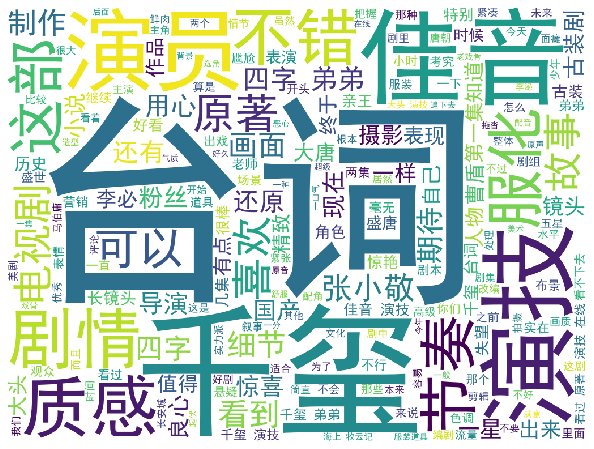

In [61]:
#参数分别是指定字体、背景颜色、最大的词的大小、使用给定图作为背景形状
wc = WordCloud(width=1024,height=768,background_color='white',
  font_path='Users/wangyutian/Library/Fonts/simhei.ttf',
  stopwords=stopwords,max_font_size=400,
  random_state=50)
wc.generate_from_text(comment_cut)
plt.figure(figsize=(16, 8))
plt.imshow(wc)
plt.axis('off')#不显示坐标轴  
# wc.to_file('wordcloud.png')
plt.show()

- 词云图来看，观众对这部剧评价还可以。看到大家评论最多的就是 "台词" 和 "千玺"，观众中有很多易烊千玺的粉丝啊，说明之前的观众地域分布图是合理的。
- 还有个发现就是很多公众号都说这部剧对唐朝还原度很高，可是从词云图来看，也就一般般啊。

## 4、观众评论数量与日期的关系

In [80]:
# 解析日期
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y%m%d')
df['date'] = pd.to_datetime(df.date, format='%Y%m%d')
df_score = df.pivot_table(index='date',columns='score',values='score1',aggfunc='count')

In [109]:
from pyecharts.charts import Bar
from pyecharts import options as opts
# 内置主题类型可查看 pyecharts.globals.ThemeType
from pyecharts.globals import ThemeType

bar = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
    .add_xaxis(["6月27日", "6月28日", "6月29日", "6月30日", "7月1日", "7月2日"])
    .add_yaxis("还行", [4, 13, 1, 3, 1, 0])
    .add_yaxis("很差", [6, 91, 23, 9, 12, 4])
    .add_yaxis("较差", [18, 47, 13, 3, 1, 2])
    .add_yaxis("力荐", [46, 39, 53, 3, 0, 0])
    .add_yaxis("推荐", [70, 6, 8, 1, 0, 0])
    .set_global_opts(title_opts=opts.TitleOpts(title="各评分数量与日期关系", subtitle="数据来源豆瓣"))
)
# bar.render('各评分数量与日期关系.html')
bar.render_notebook()

- 从评论的日期可以看出，上映前两天的评论数较多，之后开始呈下降趋势
- 上映前三天都有一定的推荐人数，但是第二天差评人数明显居多，30号之后基本没有推荐人数
- 总体来说热度在下降

## 各评分占比

In [113]:
score_counts = df[df['score1'] != '--']['score1'].value_counts()
attr = score_counts.index.tolist()
value = score_counts[attr].tolist()
a = dict(zip(attr,value))
data1 = []
for k in a.items():
    data1.append(list(k))


In [114]:
def pie_base() -> Pie:
    c = (
        Pie()
        .add("",data1)
        .set_global_opts(title_opts=opts.TitleOpts(title="各评分占比"))
        .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {d}%"))
    )
    return c
# pie_base().render('各评分占比.html')
pie_base().render_notebook()

结合评分占比和各评分数量与日期关系图看，并没有网传的口碑那么好，好评和差评都没有呈现出压倒的优势，但是从词云图来看，好评的观众中可能四字弟弟的粉丝比较多，所以点评时存在主观性较强的可能。

In [115]:
from snownlp import SnowNLP

In [116]:
df.head()

,user_id,name,score,comment,date,score1,city
0,0,tianya无泪,4,易烊千玺的李必真的很棒了，第一部影视化作品四字弟弟太值得夸。看似清高孤傲，实际情义双全。他演...,2019-06-27,推荐,石家庄市
1,1,吹哥,4,期待这部剧很久了，感觉唐朝的还原度非常高，装饰的道具都很真实。剧中人物的服装非常精致，就是漂...,2019-06-27,推荐,
2,2,ECHOT,1,希望越大失望越大，一口气看了四五集，不知所云，画面很美，只不过给B站剪辑手提供了很多空境素材...,2019-06-28,很差,
3,3,陈词,4,雷佳音真是把张小敬的匪气，轻浮，外粗内细演活了。最喜欢他死牢里一抬眼的那股子“狠”劲儿，不想...,2019-06-27,推荐,西安市
4,4,雨YING,1,台词太差了，完全没有起伏，出戏,2019-06-28,很差,


In [117]:

motion_list = []
for i in df['comment']:
    try:
        s = round(SnowNLP(i).sentiments, 2)
        motion_list.append(s)
    except TypeError:
        continue
result = {}
for i in set(motion_list):
    result[i] = motion_list.count(i)


## 基于snownlp的观众情感分析观

In [118]:
attr1, val1 = [], []
info = result
info = sorted(info.items(), key=lambda x: x[0], reverse=False)
for each in info[:-1]:
    attr1.append(each[0])
    val1.append(each[1])

In [119]:
b = dict(zip(attr1,val1))
data2 = []
for k in b.items():
    data2.append(list(k))


In [120]:
str_attr = []
for i in attr1:
    str_attr.append(str(i))


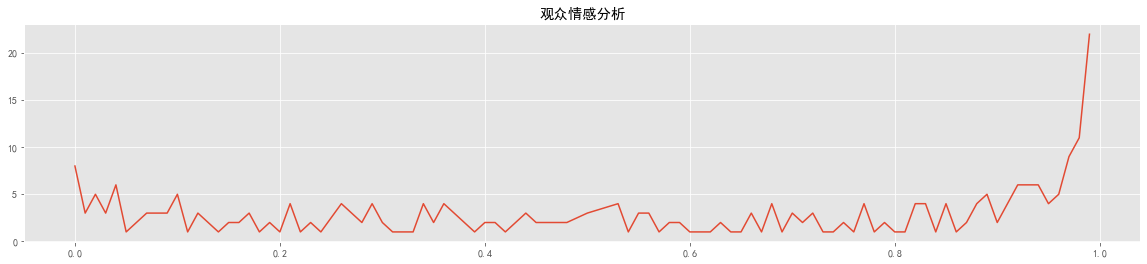

In [121]:
plt.style.use('ggplot')
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False # 显示负数
plt.figure(figsize=(20,4))
plt.plot(attr1,val1)
plt.title('观众情感分析')
# plt.savefig('观众情感分析.jpg')
plt.show()

In [122]:
# 是否显示标签
def line_base() -> Line:
    c = (
        Line(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
        .add_xaxis(str_attr)
        .add_yaxis('',val1,is_smooth=True,is_symbol_show=True)

        .set_global_opts(title_opts=opts.TitleOpts(title="观众情感分析"))
        .set_series_opts(label_opts=opts.MarkPointOpts(symbol='circle'))
    )
    return c
# line_base().render('观众情感分析.html')
line_base().render_notebook()

0.5 以下为消极，0.5 以上为积极。从情感分析来看可以看到好评还是很不错的，至于豆瓣上一些看衰评论只是少数。

###### 从这份数据来看，《长安十二时辰》口碑还是不错的，但没有网传的那么夸张，也许是四字弟弟带来了很多流量吧。。。